In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
from sklearn.metrics import accuracy_score, f1_score, classification_report


df = pd.read_csv('./data/train_data.csv')


### Détection des Outliers


In [47]:
# Sélection des variables continues
continuous_features = ["CreditScore", "Age", "Balance", "EstimatedSalary"]

# # Calcul des quartiles
# Q1 = df[continuous_features].quantile(0.25)
# Q3 = df[continuous_features].quantile(0.75)
# IQR = Q3 - Q1

# # Définir les bornes
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Appliquer un "clip" sur Age (trop d'outliers pour être supprimés)
# df["Age"] = df["Age"].clip(lower=lower_bound["Age"], upper=upper_bound["Age"])

# # Supprimer les outliers de CreditScore (seulement 230 lignes impactées)
# df = df[~((df["CreditScore"] < lower_bound["CreditScore"]) | (df["CreditScore"] > upper_bound["CreditScore"]))]

### Encodage des Variables Catégorielles

In [48]:
# Encodage des Variables Catégorielles
categorical_cols = ["Geography", "Gender"]
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' pour éviter la multicolinéarité

# Appliquer One-Hot Encoding sur train_data
encoded_data = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Fusionner avec le dataset et supprimer les anciennes colonnes
df = df.drop(columns=categorical_cols).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

df.head()  # Vérification des colonnes encodées



,ID,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,37765,15794860,Ch'eng,627,28.0,7,131694.04,1,1.0,1.0,161205.61,0,0.0,0.0,1.0
1,130453,15728005,Hargreaves,597,34.0,2,0.00,2,0.0,1.0,181419.29,0,0.0,0.0,1.0
2,77297,15686810,Ts'ui,724,39.0,7,0.00,2,1.0,1.0,100862.54,0,0.0,0.0,1.0
3,40858,15760244,Trevisano,663,56.0,5,118577.24,3,1.0,0.0,61164.45,1,1.0,0.0,0.0
4,19804,15810563,French,627,33.0,5,0.00,2,1.0,1.0,103737.82,0,0.0,0.0,0.0


### Feature Engineering


In [49]:
df["HasBalance"] = (df["Balance"] > 0).astype(int)
df['AgeByBalance'] = df['Age'] * df['Balance']
df['BalanceMinusEstimatedSalary'] = df['Balance'] - df['EstimatedSalary']   
df["BalanceToSalaryRatio"] = df["Balance"] / (df["EstimatedSalary"] + 1)  # Ratio entre Balance et salaire
df["AgeByProducts"] = df["Age"] * df["NumOfProducts"]  # Âge multiplié par le nombre de produits détenus
df["IsHighBalance"] = (df["Balance"] > df["Balance"].median()).astype(int)  # Balance élevée ou non
df['AgeCat']



### Feature Selection

In [50]:
df = df.drop(columns=["CustomerId", "Surname", "ID", "Tenure", "HasCrCard", "CreditScore", "EstimatedSalary"])  # Suppression des colonnes non utiles

### Normalisations

In [51]:
# Liste des variables continues à normaliser
cols_to_normalize = ["Age", "Balance"]

# Appliquer StandardScaler
scaler = StandardScaler()
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


### Machine Learning

[LightGBM] [Info] Number of positive: 24360, number of negative: 90503
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1259
[LightGBM] [Info] Number of data points in the train set: 114863, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212079 -> initscore=-1.312441
[LightGBM] [Info] Start training from score -1.312441
🎯 Nouveau Seuil = 0.56
🎯 Accuracy sur validation set = 0.8567
🎯 F1-score sur validation set = 0.6599
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     22626
           1       0.66      0.66      0.66      6090

    accuracy                           0.86     28716
   macro avg       0.79      0.78      0.78     28716
weighted avg       0.86      0.86      0.86     28716



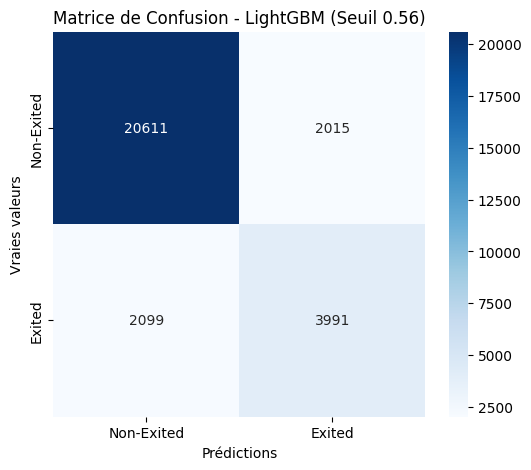

✅ Modèle LightGBM optimisé sauvegardé sous 'lgbm_optimized.pkl'


In [52]:
import lightgbm as lgb
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Définir les features (X) et la cible (y)
X = df.drop(columns=["Exited"])  # Toutes les variables sauf la cible
y = df["Exited"]  # Variable cible (churn)

# Séparer les données en train et validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialiser LightGBM avec les hyperparamètres optimisés
lgbm_model = lgb.LGBMClassifier(
    max_depth=8,
    num_leaves=56,
    min_child_samples=44,
    subsample=0.5962739754421336,
    colsample_bytree=0.6296488745154157,
    learning_rate=0.0100607081062702,
    n_estimators=150,
    reg_alpha=4.219608242542127,
    reg_lambda=0.3784972479255768,
    random_state=42,
    is_unbalance=True
)

# Entraîner le modèle
lgbm_model.fit(X_train, y_train)

# Prédictions des probabilités sur le jeu de validation
y_val_proba = lgbm_model.predict_proba(X_val)[:, 1]  # Probabilité d'appartenir à la classe "Exited"

# Définir un seuil de décision différent
new_threshold = 0.56  # Expérimente avec 0.35, 0.4, 0.45...

# Convertir les probabilités en classes en appliquant le seuil
y_val_pred = (y_val_proba >= new_threshold).astype(int)

# Évaluation du modèle avec le nouveau seuil
acc_val = accuracy_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

print(f"🎯 Nouveau Seuil = {new_threshold}")
print(f"🎯 Accuracy sur validation set = {acc_val:.4f}")
print(f"🎯 F1-score sur validation set = {f1_val:.4f}")
print(classification_report(y_val, y_val_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Exited", "Exited"], yticklabels=["Non-Exited", "Exited"])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title(f"Matrice de Confusion - LightGBM (Seuil {new_threshold})")
plt.show()


# Sauvegarder le modèle entraîné
joblib.dump(lgbm_model, "lgbm_optimized.pkl")
print("✅ Modèle LightGBM optimisé sauvegardé sous 'lgbm_optimized.pkl'")







In [53]:
# Charger test_data.csv
df_test = pd.read_csv("./data/test_data.csv")

# Vérifier que la colonne ID existe (nécessaire pour Kaggle)
if "ID" not in df_test.columns:
    raise ValueError("❌ ERREUR : La colonne 'ID' est absente de test_data.csv, Kaggle en a besoin.")

# Appliquer exactement le même preprocessing sur test_data.csv que sur train_data.csv

### Détection des Outliers
df_test["Age"] = df_test["Age"].clip(lower=lower_bound["Age"], upper=upper_bound["Age"])
df_test["CreditScore"] = df_test["CreditScore"].clip(lower=lower_bound["CreditScore"], upper=upper_bound["CreditScore"])
df_test["Balance"] = df_test["Balance"].clip(lower=lower_bound["Balance"], upper=upper_bound["Balance"])
df_test["EstimatedSalary"] = df_test["EstimatedSalary"].clip(lower=lower_bound["EstimatedSalary"], upper=upper_bound["EstimatedSalary"])

### Encodage des Variables Catégorielles
encoded_test = encoder.transform(df_test[categorical_cols])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols))

# Fusionner avec le dataset et supprimer les anciennes colonnes
df_test = df_test.drop(columns=categorical_cols).reset_index(drop=True)
df_test = pd.concat([df_test, encoded_test_df], axis=1)

### Feature Engineering
df_test["HasBalance"] = (df_test["Balance"] > 0).astype(int)
df_test['AgeByBalance'] = df_test['Age'] * df_test['Balance']
df_test['BalanceMinusEstimatedSalary'] = df_test['Balance'] - df_test['EstimatedSalary']   
df_test["BalanceToSalaryRatio"] = df_test["Balance"] / (df_test["EstimatedSalary"] + 1)  # Ratio entre Balance et salaire
df_test["AgeByProducts"] = df_test["Age"] * df_test["NumOfProducts"]  # Âge multiplié par le nombre de produits détenus
df_test["IsHighBalance"] = (df_test["Balance"] > df_test["Balance"].median()).astype(int)  # Balance élevée ou non

### Normalisation
df_test[cols_to_normalize] = scaler.transform(df_test[cols_to_normalize])

# Conserver la colonne 'ID' dans df_test avant de faire la sélection des features
df_test_input = df_test[X.columns]  # Appliquer exactement les mêmes colonnes utilisées pour entraîner le modèle


print(f"✅ Test set après preprocessing : {df_test_input.shape[0]} lignes, {df_test_input.shape[1]} colonnes")



✅ Test set après preprocessing : 21455 lignes, 13 colonnes


In [54]:
# Charger le modèle Random Forest sauvegardé
lgbm = joblib.load("lgbm_optimized.pkl")

# Prédire avec le modèle sur test_data
y_test_pred = lgbm.predict(df_test_input)

# Créer le DataFrame de soumission sans ajouter d'index inutile
submission = pd.DataFrame({
    "ID": df_test["ID"],  # Remettre la colonne 'ID' dans le DataFrame
    "Exited": y_test_pred  # Ajouter les prédictions
})

# Sauvegarder le fichier CSV pour Kaggle **sans nom de colonne pour l'index**
submission.to_csv("submission.csv", index=False)  # index=False pour ne pas inclure d'index supplémentaire

# Confirmer que le fichier a été sauvegardé correctement
print("✅ Fichier 'submission.csv' généré avec succès ! 🎯")




✅ Fichier 'submission.csv' généré avec succès ! 🎯
